In [ ]:
!pip install Sastrawi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download as nltk_download
nltk_download('punkt')
nltk_download('stopwords')
nltk_download('wordnet')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Bidirectional, MaxPooling1D, Flatten, GRU, SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import requests
import csv
from io import StringIO
import tensorflow as tf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df = pd.read_csv('data_scraping_tiktok.csv')

df.shape

(30000, 11)

In [ ]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,94cf598f-11a9-45e9-8e12-a696acb10b98,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"ini tiktok kok Tambah eror si,tdk bisa live,nnton live juga tdk bisa,alasan.x Masi di bawah umur 18 tahun,SDH di ajukan banding untuk perbaiki TPI TDK di terima cuy padahal jelas2 SDH ada foto ID,dan umur juga SDH 23 masa gitu aja ribet baget",3,0,NaN,2025-05-02 12:06:33,NaN,NaN,NaN
1,27ad4a31-5cef-44d2-a282-be2cdca1e24d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,tak boleh buat apa-apa,1,0,NaN,2025-05-02 12:06:00,NaN,NaN,NaN
2,ffc21e12-d05f-4a81-a857-6c550dbe8d78,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,mantap,5,0,39.5.5,2025-05-02 12:05:47,NaN,NaN,39.5.5
3,5ebf6047-1be4-4012-b790-57d26551fa7a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,tiktok sy kadang susah dibuka trus ni sy coba nginstal lgi ..knp ya,4,0,NaN,2025-05-02 12:05:47,NaN,NaN,NaN
4,6318d4ba-060a-4b4c-8438-0d6b78e5a875,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"saya suka banget dengan aplikasi tiktok ini , tapi tolong jangan di bikin bug lagi untuk mendownload tiktok",1,0,38.3.3,2025-05-02 12:05:36,NaN,NaN,38.3.3


In [ ]:
# Convert the 'at' column to datetime
df['at'] = pd.to_datetime(df['at'])

# Filter 2024-2025
df_2024_2025 = df[(df['at'].dt.year == 2024) | (df['at'].dt.year == 2025)]

# Eksplorasi
print(f"Jumlah data 2024-2025: {len(df_2024_2025)}")
print("\nDistribusi rating:")
print(df_2024_2025['score'].value_counts())
print("\nMissing values:")
print(df_2024_2025.isnull().sum())
print("\nSampel teks:")
print(df_2024_2025['content'].head(10))

Jumlah data 2024-2025: 30000

Distribusi rating:
score
5    14073
1     8383
3     2563
4     2533
2     2448
Name: count, dtype: int64

Missing values:
reviewId                    0
userName                    0
userImage                   0
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion    12209
at                          0
replyContent            29987
repliedAt               29987
appVersion              12209
dtype: int64

Sampel teks:
0    ini tiktok kok Tambah eror si,tdk bisa live,nnton live juga tdk bisa,alasan.x Masi di bawah umur 18 tahun,SDH di ajukan banding untuk perbaiki TPI TDK di terima cuy padahal jelas2 SDH ada foto ID,dan umur juga SDH 23 masa gitu aja ribet baget
1                                                                                                                                                                                                                                tak boleh buat ap

In [ ]:
# Drop specified columns
df_2024_2025 = df_2024_2025.drop(columns=['thumbsUpCount', 'reviewCreatedVersion', 'replyContent', 'repliedAt', 'appVersion', 'reviewId','userName', 'userImage']) # Only drop the existing columns

In [ ]:
df = df_2024_2025

In [ ]:
df.head()

,content,score,at
0,"ini tiktok kok Tambah eror si,tdk bisa live,nnton live juga tdk bisa,alasan.x Masi di bawah umur 18 tahun,SDH di ajukan banding untuk perbaiki TPI TDK di terima cuy padahal jelas2 SDH ada foto ID,dan umur juga SDH 23 masa gitu aja ribet baget",3,2025-05-02 12:06:33
1,tak boleh buat apa-apa,1,2025-05-02 12:06:00
2,mantap,5,2025-05-02 12:05:47
3,tiktok sy kadang susah dibuka trus ni sy coba nginstal lgi ..knp ya,4,2025-05-02 12:05:47
4,"saya suka banget dengan aplikasi tiktok ini , tapi tolong jangan di bikin bug lagi untuk mendownload tiktok",1,2025-05-02 12:05:36


In [ ]:
# 1. Cek info awal
print("Jumlah baris dan kolom:", df.shape)
print("\nInfo dataframe:")
print(df.info())
print("\nJumlah missing value per kolom:")
print(df.isnull().sum())

Jumlah baris dan kolom: (30000, 3)

Info dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   content  30000 non-null  object        
 1   score    30000 non-null  int64         
 2   at       30000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 703.3+ KB
None

Jumlah missing value per kolom:
content    0
score      0
at         0
dtype: int64


In [ ]:
df['content'].head(5)

,content
0,"ini tiktok kok Tambah eror si,tdk bisa live,nnton live juga tdk bisa,alasan.x Masi di bawah umur 18 tahun,SDH di ajukan banding untuk perbaiki TPI TDK di terima cuy padahal jelas2 SDH ada foto ID,dan umur juga SDH 23 masa gitu aja ribet baget"
1,tak boleh buat apa-apa
2,mantap
3,tiktok sy kadang susah dibuka trus ni sy coba nginstal lgi ..knp ya
4,"saya suka banget dengan aplikasi tiktok ini , tapi tolong jangan di bikin bug lagi untuk mendownload tiktok"


In [ ]:
# 7. (Opsional) Cek distribusi skor sebagai dasar labeling
print("\nDistribusi skor:")
print(df['score'].value_counts())


Distribusi skor:
score
5    14073
1     8383
3     2563
4     2533
2     2448
Name: count, dtype: int64


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

# Download the necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab') # Download the punkt_tab resource

# 1. Melihat isi kolom `content`
print("Contoh isi kolom 'content':")
print(df['content'].head())  # Menampilkan 5 baris pertama

# 2. Mencari kata yang paling banyak keluar
def preprocess_text(text):
    """Melakukan preprocessing teks."""
    text = text.lower()  # Case folding
    tokens = word_tokenize(text)  # Tokenization
    stop_words = set(stopwords.words('english'))  # Stop word removal
    tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatization
    return tokens

# Mengumpulkan semua kata dari kolom 'content'
all_words = []
for text in df['content']:
    all_words.extend(preprocess_text(text))

# Menghitung frekuensi kemunculan setiap kata
word_freq = Counter(all_words)

# Menampilkan 10 kata yang paling sering muncul
print("\n20 kata yang paling sering muncul:")
print(word_freq.most_common(20))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Contoh isi kolom 'content':
0    ini tiktok kok Tambah eror si,tdk bisa live,nnton live juga tdk bisa,alasan.x Masi di bawah umur 18 tahun,SDH di ajukan banding untuk perbaiki TPI TDK di terima cuy padahal jelas2 SDH ada foto ID,dan umur juga SDH 23 masa gitu aja ribet baget
1                                                                                                                                                                                                                                tak boleh buat apa-apa
2                                                                                                                                                                                                                                                mantap
3                                                                                                                                                                                   tiktok sy kadang susah dibuka trus ni sy coba ng

In [ ]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Unduh stopwords dan tokenizer
nltk.download('punkt')
nltk.download('stopwords')

# 1. Cleaning text
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Hapus mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Hapus hashtags
    text = re.sub(r'RT[\s]+', '', text)  # Hapus RT
    text = re.sub(r"http\S+", '', text)  # Hapus linkstext = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca
    text = re.sub(r'[0-9]+', '', text)  # Hapus numbers
    text = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca
    text = text.replace('\n', ' ')  # Ganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation))  # Hapus tanda baca lagi
    text = text.strip()  # Hapus spasi di awal dan akhir
    return text

# 2. Case folding
def casefoldingText(text):
    return text.lower()

# 3. Tokenizing
def tokenizingText(text):
    return word_tokenize(text)

def filteringText(text):
    list_stopwords = set(stopwords.words('indonesian'))
    list_stopwords_en = set(stopwords.words('english'))
    list_stopwords.update(list_stopwords_en)

    additional_stopwords = [
        'ini', 'saya', 'nya', 'si', 'aja', 'ajah', 'cuma', 'kok', 'tuh', 'doang',
        'dah', 'eh', 'ko', 'lah', 'deh', 'ya', 'nih', 'gitu', 'kmn', 'tpi',
        'gue', 'aku', 'ku', 'dong', 'dlu', 'lgi', 'banget', 'sama', 'buat', 'kalo',
        'mau', 'pas', 'udah', 'terus', 'tadi', 'skrng',
        'admin', 'adminnya', 'min', 'minnya', 'sobat', 'kakak', 'bro', 'sis',
        'guys', 'gaes', 'gaess', 'om', 'tante',
        'woy', 'woi', 'hai', 'cuy', 'lo', 'loh', 'plis', 'woe', 'hallo', 'euy',
        'anjir', 'njir', 'sih', 'tau', 'lho', 'btw', 'cmn', 'yaa', 'yaaa', 'yh',
        'gmn', 'gmana','gmna'
        ]


    list_stopwords.update(additional_stopwords)

    return [word for word in text if word not in list_stopwords]

# 5. Stemming (Opsional, tidak dipakai default)
def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return ' '.join([stemmer.stem(word) for word in text.split()])

# 6. To sentence
def toSentence(list_words):
    return ' '.join(list_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Gabungkan semua tweet jadi satu string besar
all_text = ' '.join(df['content'].astype(str).apply(cleaningText))

# Tokenisasi manual (split by space)
all_words = all_text.split()

# Hitung frekuensi kata
word_counts = Counter(all_words)

# Ambil kata unik (yang muncul hanya sekali)
unique_words = [word for word, count in word_counts.items() if count == 1]

print("Kata-kata unik (muncul sekali saja):")
print(unique_words[:2500])  # Tampilkan 100 kata unik pertama

# Jika ingin kata unik yang tidak termasuk stopwords:
from nltk.corpus import stopwords
stopwords_id = set(stopwords.words('indonesian'))
# Tambahkan stopwords tambahan jika perlu

unique_words_clean = [w for w in unique_words if w not in stopwords_id]
print("\nKata unik tanpa stopwords:")
print(unique_words_clean[:2500])

Kata-kata unik (muncul sekali saja):
['sitdk', 'livennton', 'bisaalasanx', 'tahunSDH', 'IDdan', 'bngsa', 'heror', 'jampa', 'cintaaa', 'adeee', 'logoudah', 'negative', 'bertanyamengapa', 'dimainkanasal', 'teruspadahal', 'lohmohon', 'dibukamohon', 'masukudah', 'SESATTT', 'lagiini', 'trs²an', 'pujian', 'membanggakan', 'menyingung', 'vidiogambar', 'tapinah', 'lama²Tibatiba', 'dibukaterus', 'nyetuck', 'AD', 'SOPAN', 'LEWAT', 'SUARAH', 'KIRA', 'PERATURAN', 'AP', 'MUSNAKAN', 'baguzzz', 'ehko', 'bntng', 'tiktoknyatapi', 'tiktoktpi', 'perpanjang', 'agamasaya', 'bugmentok', 'logoabis', 'bagusbukan', 'kalilama', 'heehehe', 'terjangkau', 'ketemennn', 'obatt', 'lemarin', 'sempan', 'tlpn', 'asikkkkk', 'GNI', 'UDAHMAH', 'HAPE', 'komentarfaham', 'ditt', 'abisss', 'vidiovidio', 'Apalah', 'muluudh', 'sangàt', 'diijinkan', 'naek', 'nganuin', 'pencairannya', 'teren', 'petnah', 'Affiliate', 'Belum', 'Ntar', 'tambahi', 'scrll', 'UPTED', 'INGET', 'JANJI', 'diklaim', 'yhdah', 'dahumur', 'bocilmasa', 'Batasind

In [ ]:
# Kamus slang
slangwords = {
    'tdk': 'tidak', 'sy': 'saya', 'bgt': 'banget', 'nn': 'nanti', 'ga': 'tidak',
    'gak': 'tidak', 'tak': 'tidak', 'trus': 'terus', 'dikit': 'sedikit', 'ni': 'ini',
    'aja': 'saja', 'hp': 'handphone', 'gmn': 'gimana', 'bgmn': 'bagaimana', 'kmn': 'kemana',
    'sih': 'si', 'sm': 'sama', 'bs': 'bisa', 'klo': 'kalau', 'kl': 'kalau', 'dr': 'dari',
    'dg': 'dengan', 'tp': 'tapi', 'blm': 'belum', 'udh': 'sudah', 'ud': 'sudah', 'lg': 'lagi',
    'skrg': 'sekarang', 'brp': 'berapa', 'eror': 'error', 'erorr': 'error', 'err': 'error',
    'bgus': 'bagus', 'bgs': 'bagus', 'lemot': 'lambat', 'lambt': 'lambat', 'aplk': 'aplikasi',
    'apk': 'aplikasi', 'app': 'aplikasi', 'kzl': 'kesal', 'jgn': 'jangan', 'bkn': 'bukan',
    'gt': 'gitu', 'cb': 'coba', 'parah': 'sangat', 'jos': 'bagus', 'top': 'bagus',
    'mantab': 'mantap', 'ok': 'oke', 'oky': 'oke', 'sip': 'oke', 'tlg': 'tolong',
    'thx': 'terima kasih', 'tx': 'terima kasih', 'pls': 'tolong', 'plis': 'tolong',
    'bgtz': 'banget', 'bener': 'benar', 'bner': 'benar', 'tb': 'tiba', 'tba': 'tiba',
    'gk': 'tidak', 'nggak': 'tidak', 'ngk': 'tidak', 'gajelas': 'tidak jelas',
    'ngebuk': 'bug', 'ngestuk': 'stuck', 'nyetuck': 'stuck', 'ngadat': 'macet',
    'tt': 'tiktok', 'anj': 'anjing', 'euy': 'euy', 'smpa': 'sumpah', 'udah': 'sudah',
    'gbs': 'tidak bisa', 'gabisa': 'tidak bisa', 'ngga': 'tidak', 'kpn': 'kapan',
    'msk': 'masuk', 'cm': 'cuma', 'bbrp': 'beberapa', 'lgsg': 'langsung', 'smp': 'sampai',
    'mskpn': 'meskipun', 'krn': 'karena', 'kdg': 'kadang', 'kdng': 'kadang', 'skli': 'sekali',
    'smpe': 'sampai', 'ny': 'nya', 'sbnrnya': 'sebenarnya', 'slalu': 'selalu', 'smua': 'semua',
    'stlh': 'setelah', 'kcl': 'kecil', 'bnyk': 'banyak', 'trsprh': 'terus terang', 'mskpn': 'meskipun',
    'benerin': 'perbaiki', 'pls': 'tolong', 'pliss': 'tolong', 'sblm': 'sebelum',
    'kli': 'kali', 'bbrapa': 'beberapa', 'lg': 'lagi', 'msk': 'masuk', 'km': 'kamu'
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text


In [ ]:
df.head(10)

,content,score,at
0,"ini tiktok kok Tambah eror si,tdk bisa live,nnton live juga tdk bisa,alasan.x Masi di bawah umur 18 tahun,SDH di ajukan banding untuk perbaiki TPI TDK di terima cuy padahal jelas2 SDH ada foto ID,dan umur juga SDH 23 masa gitu aja ribet baget",3,2025-05-02 12:06:33
1,tak boleh buat apa-apa,1,2025-05-02 12:06:00
2,mantap,5,2025-05-02 12:05:47
3,tiktok sy kadang susah dibuka trus ni sy coba nginstal lgi ..knp ya,4,2025-05-02 12:05:47
4,"saya suka banget dengan aplikasi tiktok ini , tapi tolong jangan di bikin bug lagi untuk mendownload tiktok",1,2025-05-02 12:05:36
5,kenapa tik tok cuma logo nya aja yang ada ditungguin pun nggak muncul muncul vidio nya udh saya uninstall pun tetap nggak bisa,2,2025-05-02 12:05:36
6,bagus cuma agak kecewa aja soalnya hp android tidak bisa foto live,3,2025-05-02 12:05:19
7,Seru banget scroll aku sampai scroll terus,5,2025-05-02 12:04:45
8,"dikit-dikit akun ke blokir, tiktok ga jelas!!!!",1,2025-05-02 12:04:31
9,bagus,5,2025-05-02 12:03:55


In [ ]:
# Menampilkan dataset yang belum dibersihkan
df.head(10)

,content,score,at
0,"ini tiktok kok Tambah eror si,tdk bisa live,nnton live juga tdk bisa,alasan.x Masi di bawah umur 18 tahun,SDH di ajukan banding untuk perbaiki TPI TDK di terima cuy padahal jelas2 SDH ada foto ID,dan umur juga SDH 23 masa gitu aja ribet baget",3,2025-05-02 12:06:33
1,tak boleh buat apa-apa,1,2025-05-02 12:06:00
2,mantap,5,2025-05-02 12:05:47
3,tiktok sy kadang susah dibuka trus ni sy coba nginstal lgi ..knp ya,4,2025-05-02 12:05:47
4,"saya suka banget dengan aplikasi tiktok ini , tapi tolong jangan di bikin bug lagi untuk mendownload tiktok",1,2025-05-02 12:05:36
5,kenapa tik tok cuma logo nya aja yang ada ditungguin pun nggak muncul muncul vidio nya udh saya uninstall pun tetap nggak bisa,2,2025-05-02 12:05:36
6,bagus cuma agak kecewa aja soalnya hp android tidak bisa foto live,3,2025-05-02 12:05:19
7,Seru banget scroll aku sampai scroll terus,5,2025-05-02 12:04:45
8,"dikit-dikit akun ke blokir, tiktok ga jelas!!!!",1,2025-05-02 12:04:31
9,bagus,5,2025-05-02 12:03:55


In [ ]:
# Create a copy of the original DataFrame to avoid modifying the original data
clean_df = df.copy()

# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [ ]:
clean_df.head()

,content,score,at,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,"ini tiktok kok Tambah eror si,tdk bisa live,nnton live juga tdk bisa,alasan.x Masi di bawah umur 18 tahun,SDH di ajukan banding untuk perbaiki TPI TDK di terima cuy padahal jelas2 SDH ada foto ID,dan umur juga SDH 23 masa gitu aja ribet baget",3,2025-05-02 12:06:33,ini tiktok kok Tambah eror sitdk bisa livennton live juga tdk bisaalasanx Masi di bawah umur tahunSDH di ajukan banding untuk perbaiki TPI TDK di terima cuy padahal jelas SDH ada foto IDdan umur juga SDH masa gitu aja ribet baget,ini tiktok kok tambah eror sitdk bisa livennton live juga tdk bisaalasanx masi di bawah umur tahunsdh di ajukan banding untuk perbaiki tpi tdk di terima cuy padahal jelas sdh ada foto iddan umur juga sdh masa gitu aja ribet baget,ini tiktok kok tambah error sitdk bisa livennton live juga tidak bisaalasanx masi di bawah umur tahunsdh di ajukan banding untuk perbaiki tpi tidak di terima cuy padahal jelas sdh ada foto iddan umur juga sdh masa gitu saja ribet baget,"[ini, tiktok, kok, tambah, error, sitdk, bisa, livennton, live, juga, tidak, bisaalasanx, masi, di, bawah, umur, tahunsdh, di, ajukan, banding, untuk, perbaiki, tpi, tidak, di, terima, cuy, padahal, jelas, sdh, ada, foto, iddan, umur, juga, sdh, masa, gitu, saja, ribet, baget]","[tiktok, error, sitdk, livennton, live, bisaalasanx, masi, umur, tahunsdh, ajukan, banding, perbaiki, terima, sdh, foto, iddan, umur, sdh, ribet, baget]",tiktok error sitdk livennton live bisaalasanx masi umur tahunsdh ajukan banding perbaiki terima sdh foto iddan umur sdh ribet baget
1,tak boleh buat apa-apa,1,2025-05-02 12:06:00,tak boleh buat apaapa,tak boleh buat apaapa,tidak boleh buat apaapa,"[tidak, boleh, buat, apaapa]",[apaapa],apaapa
2,mantap,5,2025-05-02 12:05:47,mantap,mantap,mantap,[mantap],[mantap],mantap
3,tiktok sy kadang susah dibuka trus ni sy coba nginstal lgi ..knp ya,4,2025-05-02 12:05:47,tiktok sy kadang susah dibuka trus ni sy coba nginstal lgi knp ya,tiktok sy kadang susah dibuka trus ni sy coba nginstal lgi knp ya,tiktok saya kadang susah dibuka terus ini saya coba nginstal lgi knp ya,"[tiktok, saya, kadang, susah, dibuka, terus, ini, saya, coba, nginstal, lgi, knp, ya]","[tiktok, kadang, susah, dibuka, coba, nginstal, knp]",tiktok kadang susah dibuka coba nginstal knp
4,"saya suka banget dengan aplikasi tiktok ini , tapi tolong jangan di bikin bug lagi untuk mendownload tiktok",1,2025-05-02 12:05:36,saya suka banget dengan aplikasi tiktok ini tapi tolong jangan di bikin bug lagi untuk mendownload tiktok,saya suka banget dengan aplikasi tiktok ini tapi tolong jangan di bikin bug lagi untuk mendownload tiktok,saya suka banget dengan aplikasi tiktok ini tapi tolong jangan di bikin bug lagi untuk mendownload tiktok,"[saya, suka, banget, dengan, aplikasi, tiktok, ini, tapi, tolong, jangan, di, bikin, bug, lagi, untuk, mendownload, tiktok]","[suka, aplikasi, tiktok, tolong, bikin, bug, mendownload, tiktok]",suka aplikasi tiktok tolong bikin bug mendownload tiktok


In [ ]:
# Loads positive lexicon data from GitHub
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
reader = csv.reader(StringIO(response.text), delimiter=',')
for row in reader:
    lexicon_positive[row[0]] = int(row[1])


# Loads negative lexicon data from GitHub
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
reader = csv.reader(StringIO(response.text), delimiter=',')
for row in reader:
    lexicon_negative[row[0]] = int(row[1])

In [154]:
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    # untuk setiap kata dalam teks:

    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''
    # Inisialisasi variabel polaritas

    if (score >= 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif
    else:
        polarity = 'neutral'
    # Ini adalah bagian yang bisa digunakan untuk menentukan polaritas netral jika diperlukan

    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks

In [155]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    15910
negative    14090
Name: count, dtype: int64


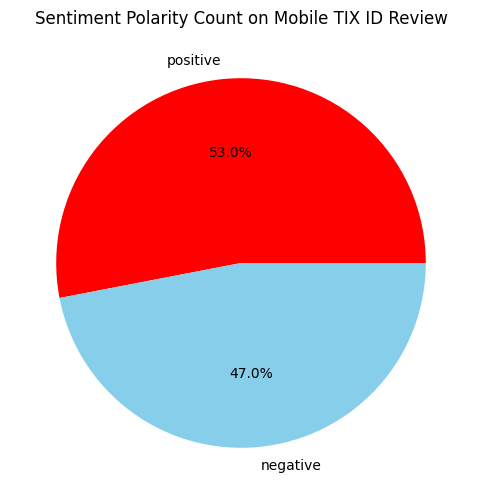

In [156]:
# Menghitung jumlah tiap polaritas
polarity_counts = clean_df['polarity'].value_counts()

# Plot diagram batang
plt.figure(figsize=(10, 6))
plt.pie(polarity_counts.values, labels=polarity_counts.index, autopct='%1.1f%%', colors=['red','skyblue'])
plt.title('Sentiment Polarity Count on Mobile TIX ID Review')
plt.show()

In [174]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]

    for word in text:
        if word in lexicon_negative:
            score += lexicon_negative[word]

    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

# Fungsi test
def test_sentiment_analysis():
    tweets = [
        "Aplikasi ini bagus sekali",
        "Jelek sekali ini aplikasi",
        "biasa saja",
        "jelek nih aplikasi",
        "Aplikasi ini bagus sekali"
    ]

    for tweet in tweets:
        words = tweet.lower().split()
        score, polarity = sentiment_analysis_lexicon_indonesia(words)
        print(f"Tweet: {tweet}")
        print(f"Score: {score}, Polarity: {polarity}")
        print("-" * 40)

# Jalankan test
test_sentiment_analysis()


Tweet: Aplikasi ini bagus sekali
Score: 2, Polarity: positive
----------------------------------------
Tweet: Jelek sekali ini aplikasi
Score: -2, Polarity: negative
----------------------------------------
Tweet: biasa saja
Score: 0, Polarity: neutral
----------------------------------------
Tweet: jelek nih aplikasi
Score: -2, Polarity: negative
----------------------------------------
Tweet: Aplikasi ini bagus sekali
Score: 2, Polarity: positive
----------------------------------------


In [175]:
#Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Membuat DataFrame baru 'positive_tweets' yang hanya berisi tweet dengan polaritas positif.
positive_tweets = clean_df[clean_df['polarity'] == 'positive']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'positive_tweets'.
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

# Mengurutkan DataFrame 'positive_tweets' berdasarkan 'polarity_score' secara menurun.
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
positive_tweets = positive_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
positive_tweets.index += 1

In [176]:
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Membuat DataFrame baru 'negative_tweets' yang hanya berisi tweet dengan polaritas negatif.
negative_tweets = clean_df[clean_df['polarity'] == 'negative']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'negative_tweets'.
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

# Mengurutkan DataFrame 'negative_tweets' berdasarkan 'polarity_score' secara menaik (ascending).
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=True)

# Memilih 10 baris pertama dari DataFrame yang sudah diurutkan.
negative_tweets = negative_tweets[0:10]

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
negative_tweets = negative_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
negative_tweets.index += 1


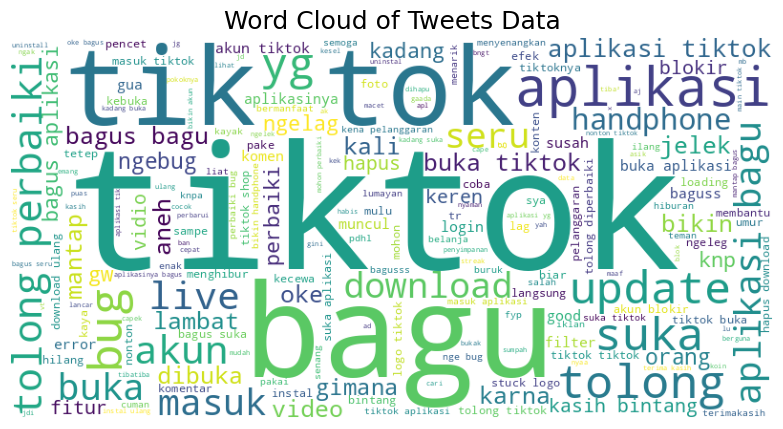

In [177]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'clean_df'.
for tweet in clean_df['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6)) # Membuat gambar dan sumbu untuk menampilkan word cloud
ax.set_title('Word Cloud of Tweets Data', fontsize=18) # Menetapkan judul untuk word cloud
ax.grid(False) # Menonaktifkan grid pada sumbu
ax.imshow((wordcloud)) # Menampilkan word cloud dalam gambar
fig.tight_layout(pad=0) # Mengatur layout gambar
ax.axis('off') # Menyembunyikan sumbu

# Menampilkan word cloud
plt.show()

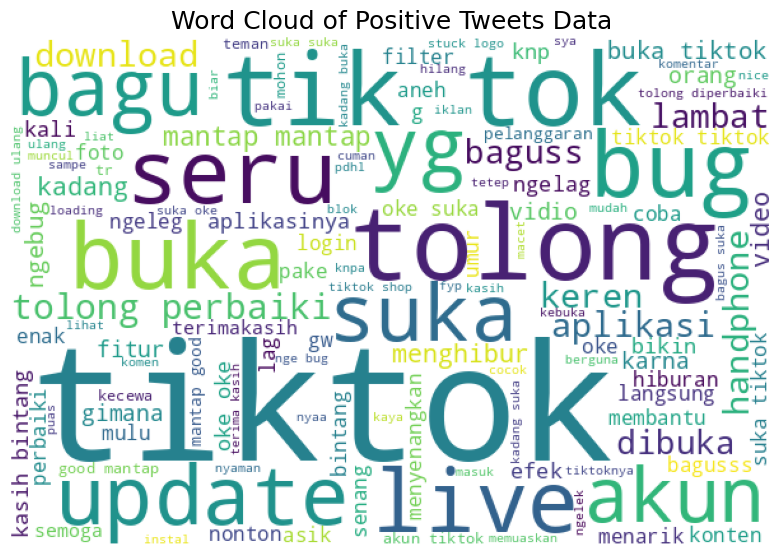

In [178]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan dalam tweet positif.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'positive_tweets'.
for tweet in positive_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Positive Tweets Data', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

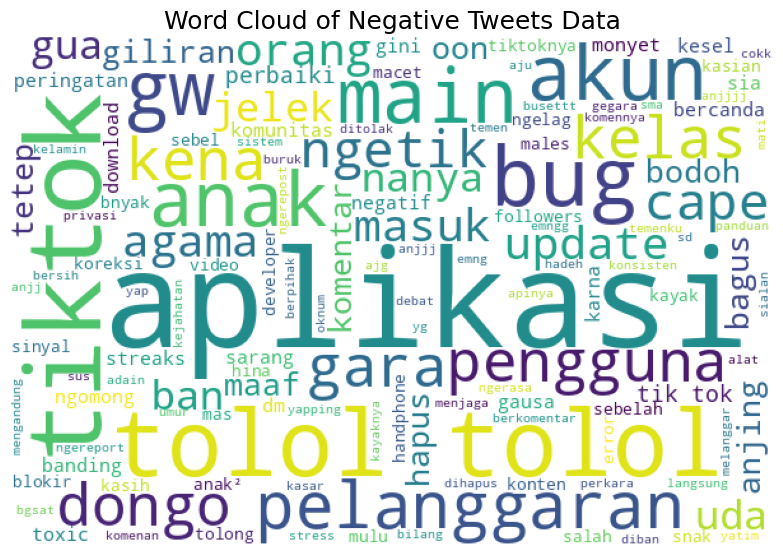

In [179]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan dalam tweet negatif.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'negative_tweets'.
for tweet in negative_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Negative Tweets Data', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

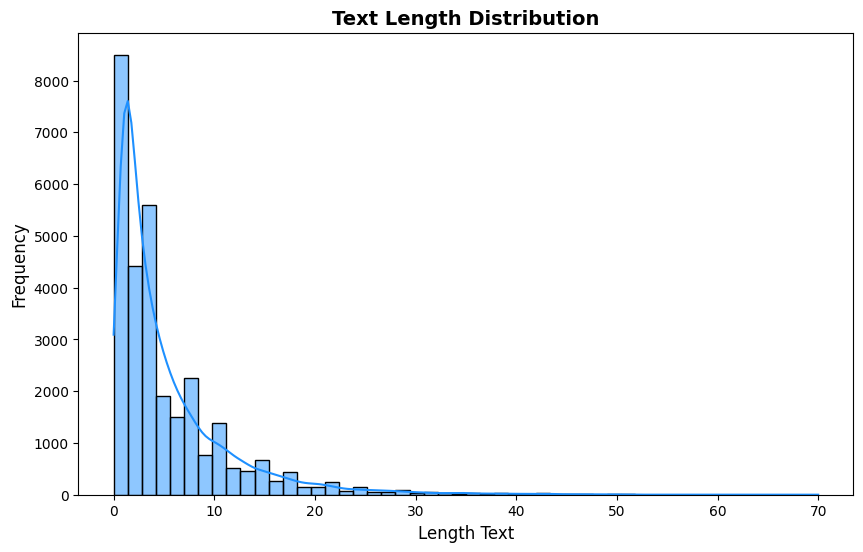

In [180]:
# Atur ukuran figure
plt.figure(figsize=(10, 6))

# Membuat distribusi panjang teks
clean_df['text_length'] = clean_df['text_akhir'].apply(lambda x: len(x.split()))

# Visualisasi distribusi panjang teks
sns.histplot(clean_df['text_length'], bins=50, kde=True, color='dodgerblue')

# Tambahkan judul dan label sumbu
plt.xlabel('Length Text', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Text Length Distribution', fontsize=14, fontweight='bold')

# Tampilkan plot
plt.show()

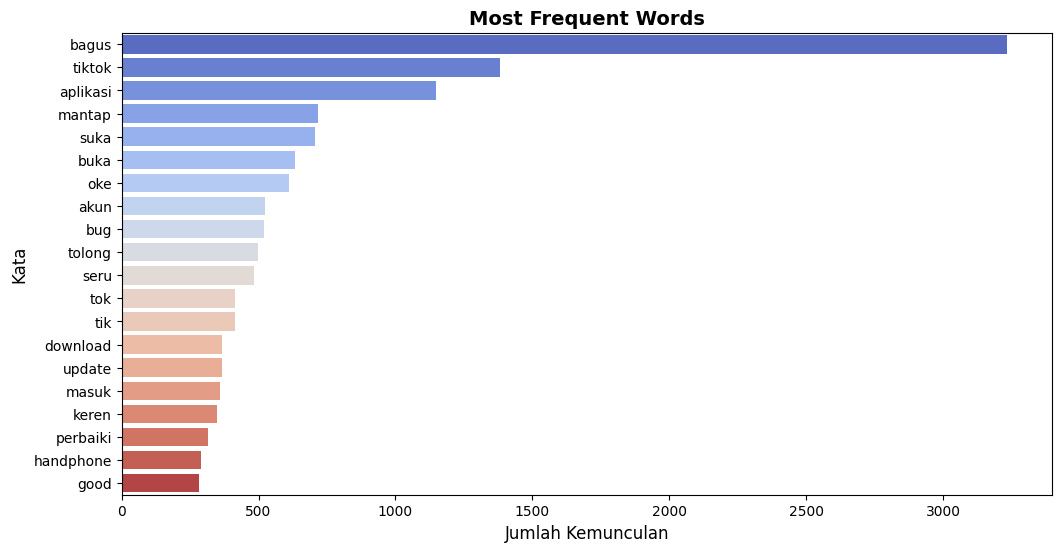

In [181]:
# Set ukuran figure
plt.figure(figsize=(12, 6))

# Visualisasi kata-kata paling sering muncul
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Hitung frekuensi setiap kata
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df.rename(columns={'index': 'kata'}, inplace=True)

# Sort berdasarkan jumlah kemunculan (frekuensi)
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)

# Menambahkan kontras warna berdasarkan frekuensi (gradient)
colors = sns.color_palette("coolwarm", len(tfidf_df))

# Membuat barplot dengan kontras warna
sns.barplot(x='jumlah', y='kata', data=tfidf_df, palette=colors, hue='kata', dodge=False)

# Mengatur legenda agar tidak tampil jika tidak dibutuhkan
plt.legend([], [], frameon=False)

# Menambahkan judul dan label sumbu
plt.title('Most Frequent Words', fontsize=14, fontweight='bold')
plt.xlabel('Jumlah Kemunculan', fontsize=12)
plt.ylabel('Kata', fontsize=12)

# Tampilkan plot
plt.show()

In [182]:
# Ekstrak teks dan labels dari cleaned dataframe
texts = clean_df['text_akhir'].tolist()
labels = clean_df['polarity'].tolist()

# Inisialisasi tokenizer dan urutkan
vocab_limit = 2500
text_tokenizer = Tokenizer(num_words=vocab_limit, split=' ')
text_tokenizer.fit_on_texts(texts)
sequences = text_tokenizer.texts_to_sequences(texts)
padded_inputs = pad_sequences(sequences)

# Encode labels ke format numerik
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

In [183]:
# Split data training dan test
X_train, X_test, y_train, y_test = train_test_split(padded_inputs, numeric_labels, test_size=0.2, random_state=42)

In [184]:
# Custom callback untuk menghentikan training jika akurasi validasi telah melebihi ambang batas/threshold
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.92:
            print(f"\nVal accuracy telah melampaui 0,92 pada epoch {epoch+1}. Pelatihan dihentikan.")
            self.model.stop_training = True

# Inisialisasi callback
early_stopping = CustomCallback()


In [186]:
# Membangun model LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau # Import ReduceLROnPlateau

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_limit, output_dim=128, input_length=padded_inputs.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.4),
    tf.keras.layers.LSTM(128, dropout=0.4, recurrent_dropout=0.4, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Optimasi: Learning rate scheduler
lr_schedule = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-5
)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

# Training model dengan callback
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_schedule],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 44s 106ms/step - accuracy: 0.6727 - loss: 0.6213 - val_accuracy: 0.9018 - val_loss: 0.2446 - learning_rate: 5.0000e-04
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9170 - loss: 0.2290
Val accuracy telah melampaui 0,92 pada epoch 2. Pelatihan dihentikan.
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 106ms/step - accuracy: 0.9171 - loss: 0.2290 - val_accuracy: 0.9325 - val_loss: 0.1829 - learning_rate: 5.0000e-04


In [187]:
# Evaluasi Model
print("\nEvaluasi Model LSTM:")

# Evaluasi pada data training
results_train_LSTM = model.evaluate(X_train, y_train, verbose=1)
print("Training Loss: %.2f" % results_train_LSTM[0])
print("Training Accuracy: %.2f" % results_train_LSTM[1])

# Evaluasi pada data testing (validation)
results_val_LSTM = model.evaluate(X_test, y_test, verbose=1)
print("Validation Loss: %.2f" % results_val_LSTM[0])
print("Validation Accuracy: %.2f" % results_val_LSTM[1])


Evaluasi Model LSTM:
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9536 - loss: 0.1400
Training Loss: 0.14
Training Accuracy: 0.95
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9310 - loss: 0.1911
Validation Loss: 0.18
Validation Accuracy: 0.93


In [188]:
# Menyimpah hasil lstm
model.save("model_lstm.h5")

##**MODEL RNN**

In [189]:
X_train, X_test, y_train, y_test = train_test_split(padded_inputs, numeric_labels, test_size=0.3, random_state=42)

In [191]:
# Arsitektur Model RNN
model_rnn = Sequential()

# Embedding Layer
model_rnn.add(Embedding(input_dim=vocab_limit, output_dim=128, input_length=padded_inputs.shape[1]))

# Multiple RNN Layers
model_rnn.add(SimpleRNN(units=128, dropout=0.3, return_sequences=True))

# Simple RNN Layer
model_rnn.add(SimpleRNN(units=128, dropout=0.3, return_sequences=False))

# Fully Connected Layers
model_rnn.add(Dense(128, activation='relu'))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(64, activation='relu'))
model_rnn.add(Dropout(0.3))

# Output Layer
model_rnn.add(Dense(len(set(numeric_labels)), activation='softmax'))

# Compile Model
model_rnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Optimasi: Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-5)

# Latih Model
history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=25,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/25
165/165 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - accuracy: 0.6731 - loss: 0.5673 - val_accuracy: 0.9134 - val_loss: 0.2205 - learning_rate: 0.0010
Epoch 2/25
164/165 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9368 - loss: 0.1855
Val accuracy telah melampaui 0,92 pada epoch 2. Pelatihan dihentikan.
165/165 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.9368 - loss: 0.1855 - val_accuracy: 0.9368 - val_loss: 0.1744 - learning_rate: 0.0010


In [192]:
# Evaluasi Model
print("\nEvaluasi Model RNN:")

# Evaluasi pada data training
results_rnn_train = model_rnn.evaluate(X_train, y_train, verbose=1)
print(f"Training Loss: {results_rnn_train[0]:.2f}")
print(f"Training Accuracy: {results_rnn_train[1]:.2f}")

# Evaluasi pada data testing (validation)
results_rnn_val = model_rnn.evaluate(X_test, y_test, verbose=1)
print(f"Validation Loss: {results_rnn_val[0]:.2f}")
print(f"Validation Accuracy: {results_rnn_val[1]:.2f}")


Evaluasi Model RNN:
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9674 - loss: 0.1003
Training Loss: 0.10
Training Accuracy: 0.97
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9372 - loss: 0.1815
Validation Loss: 0.17
Validation Accuracy: 0.94


In [195]:
# Menyimpah hasil lstm
model.save("models_rrn.h5") # Changed the extension from .hhas to .h5

##**Model 3: CNN (70/30 Split)**

In [196]:
# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(padded_inputs, numeric_labels, test_size=0.3, random_state=42)

In [197]:
# Arsitektur Model CNN
model_cnn = Sequential()

# Embedding Layer
model_cnn.add(Embedding(input_dim=vocab_limit, output_dim=128, input_length=padded_inputs.shape[1]))

# Multipel Conv1D Layer
model_cnn.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())

# Fully Connected Layer dengan Dropout
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.5))

# Output Layer untuk klasifikasi multi-kelas
model_cnn.add(Dense(len(set(numeric_labels)), activation='softmax'))

# Optimasi: learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-5
)

# Compile Model
model_cnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Latih Model
history_cnn = model_cnn.fit(
    X_train, y_train,
    epochs=25,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


164/165 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7410 - loss: 0.4929
Val accuracy telah melampaui 0,92 pada epoch 1. Pelatihan dihentikan.
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - accuracy: 0.7423 - loss: 0.4910 - val_accuracy: 0.9300 - val_loss: 0.1799 - learning_rate: 0.0010


In [198]:
# Evaluasi Model
print("\nEvaluasi Model CNN:")

# Evaluasi pada data training
results_cnn_train = model_cnn.evaluate(X_train, y_train, verbose=1)
print(f"Training Loss: {results_cnn_train[0]:.2f}")
print(f"Training Accuracy: {results_cnn_train[1]:.2f}")

# Evaluasi pada data testing (validation)
results_cnn_val = model_cnn.evaluate(X_test, y_test, verbose=1)
print(f"Validation Loss: {results_cnn_val[0]:.2f}")
print(f"Validation Accuracy: {results_cnn_val[1]:.2f}")


Evaluasi Model CNN:
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9557 - loss: 0.1233
Training Loss: 0.12
Training Accuracy: 0.96
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9239 - loss: 0.1922
Validation Loss: 0.18
Validation Accuracy: 0.93


In [199]:
# Menyimpah hasil lstm
model.save("models_cnn.h5") # Changed the extension from .hhas to .h5

##**Model 4: GRU (80/20 Split)**

In [201]:
from tensorflow.keras.layers import BatchNormalization # Add this line
# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(padded_inputs, numeric_labels, test_size=0.2, random_state=42)

# Arsitektur Model GRU
model_gru = Sequential()

# Embedding Layer
model_gru.add(Embedding(input_dim=vocab_limit, output_dim=256, input_length=padded_inputs.shape[1]))

# Multiple GRU Layers
model_gru.add(GRU(units=256, dropout=0.3, recurrent_dropout=0.3, return_sequences=False))

# Fully Connected Layers
model_gru.add(Dense(128, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.3))
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dropout(0.3))

# Output Layer Softmax
model_gru.add(Dense(len(set(numeric_labels)), activation='softmax'))

# Compile Model
model_gru.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Optimasi: Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-5
)

# Pelatihan Model
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 136s 682ms/step - accuracy: 0.8088 - loss: 0.3935 - val_accuracy: 0.9155 - val_loss: 0.3882 - learning_rate: 0.0010
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9462 - loss: 0.1597
Val accuracy telah melampaui 0,92 pada epoch 2. Pelatihan dihentikan.
188/188 ━━━━━━━━━━━━━━━━━━━━ 101s 533ms/step - accuracy: 0.9461 - loss: 0.1597 - val_accuracy: 0.9478 - val_loss: 0.1686 - learning_rate: 0.0010


In [202]:
# Evaluasi Model
print("\nEvaluasi Model GRU:")

# Evaluasi pada data training
results_gru_train = model_gru.evaluate(X_train, y_train, verbose=1)
print(f"Training Loss: {results_gru_train[0]:.2f}")
print(f"Training Accuracy: {results_gru_train[1]:.2f}")

# Evaluasi pada data testing (validation)
results_gru_val = model_gru.evaluate(X_test, y_test, verbose=1)
print(f"Validation Loss: {results_gru_val[0]:.2f}")
print(f"Validation Accuracy: {results_gru_val[1]:.2f}")



Evaluasi Model GRU:
750/750 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - accuracy: 0.9737 - loss: 0.1276
Training Loss: 0.13
Training Accuracy: 0.97
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9449 - loss: 0.1734
Validation Loss: 0.17
Validation Accuracy: 0.95


In [206]:
model.save("model_gru.h5")

##**Evaluasi Model**

In [203]:
# Dictionary hasil evaluasi
models_results = {
    "LSTM": [results_train_LSTM[1], results_val_LSTM[1]],
    "RNN": [results_rnn_train[1], results_rnn_val[1]],
    "CNN": [results_cnn_train[1], results_cnn_val[1]],
    "GRU": [results_gru_train[1], results_gru_val[1]]
}

# Membuat DataFrame
df_accuracy = pd.DataFrame.from_dict(models_results, orient='index', columns=["Training Accuracy", "Validation Accuracy"])

# Menampilkan DataFrame
df_accuracy

,Training Accuracy,Validation Accuracy
LSTM,0.954833,0.932500
RNN,0.966714,0.936778
CNN,0.957429,0.930000
GRU,0.973167,0.947833


# **Prediksi**

In [207]:
# Memuat model lstm
model = tf.keras.models.load_model('model_gru.h5')

# Input teks baru
new_texts = ["aplikasi tolol banyak bug nya bangsat"]
# Tokenisasi dengan tokenizer yang sudah digunakan saat pelatihan
new_sequences = text_tokenizer.texts_to_sequences(new_texts)
new_padded_inputs = pad_sequences(new_sequences, maxlen=padded_inputs.shape[1])

# Prediksi menggunakan model yang telah dimuat
predictions_LSTM = model.predict(new_padded_inputs)

# Konversi ke kelas kategorikal
categorical_class = ["negatif", "positif", "netral"]
predicted_labels_LSTM = categorical_class[np.argmax(predictions_LSTM, axis=1)[0]]

# Menampilkan hasil prediksi
print(f"\nKalimat: {new_texts[0]}")
print(f"Sentimen: {predicted_labels_LSTM}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step

Kalimat: aplikasi tolol banyak bug nya bangsat
Sentimen: negatif
